#**Dampak Standardisasi Model Emosi dan Kualitas Dataset terhadap Generalisasi Sistem Deteksi Emosi Multi-label Berbahasa Indonesia**

#**1. Persiapan Lingkungan dan Dataset**

##**1.1 Instalasi dan Impor Dependensi**

In [ ]:
# Instalasi library yang dibutuhkan
!pip install datasets pandas numpy scikit-learn torch transformers Sastrawi nltk textstat gensim

In [ ]:
# Impor pustaka utama
import pandas as pd
import numpy as np
import torch
import re
import os
import math
import requests
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import google.generativeai as genai

# Impor pustaka PyTorch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset as TorchDataset

# Impor dari Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
from transformers.training_args import IntervalStrategy

# Impor dari Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer

# Impor dari NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')

RANDOM_SEED = 42

# Impor dari Sastrawi
sastrawi_stemmer = None
sastrawi_stopword_remover = None
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
    sastrawi_stemmer = StemmerFactory().create_stemmer()
    sastrawi_stopword_remover = StopWordRemoverFactory().create_stop_word_remover()
except ImportError:
    print("Sastrawi tidak terinstal. Tidak akan digunakan.")
    pass

# Impor dari gensim (untuk Word Embeddings)
from gensim.models import KeyedVectors, Word2Vec

print("\nSemua dependensi telah diinstal dan diimpor.")


Semua dependensi telah diinstal dan diimpor.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


##**1.2 Akses dan Konsolidasi Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_path_anotasi = '/content/drive/MyDrive/Data_NLP/df_anotasi.parquet'
dev_path = "/content/drive/MyDrive/Data_NLP/dev-00000-of-00001.parquet"
test_path = "/content/drive/MyDrive/Data_NLP/test-00000-of-00001.parquet"

df_anotasi = pd.read_parquet(df_path_anotasi)
df_dev = pd.read_parquet(dev_path)
df_test = pd.read_parquet(test_path)

df_semeval = pd.concat([df_dev, df_test], ignore_index=True)
df_semeval = df_semeval.drop('id', axis=1)

df_full_dataset = pd.concat([df_anotasi, df_semeval], ignore_index=True)

df_full_dataset = df_full_dataset[df_full_dataset['emotions'].notna() & (df_full_dataset['emotions'].apply(lambda x: len(x) > 0))]

# --- Penanganan Kombinasi Label Langka untuk Stratifikasi ---
df_full_dataset['emotions_tuple'] = df_full_dataset['emotions'].apply(lambda x: tuple(sorted(x)))
combination_counts = Counter(df_full_dataset['emotions_tuple'])

RARE_COMBINATION_THRESHOLD = 5
rare_combinations = [
    combo for combo, count in combination_counts.items()
    if count < RARE_COMBINATION_THRESHOLD
]

if rare_combinations:
    print(f"Peringatan: Ditemukan {len(rare_combinations)} kombinasi label langka (muncul < {RARE_COMBINATION_THRESHOLD} kali).")
    print("Kombinasi ini akan dikelompokkan menjadi ['rare_combination'].")
    df_full_dataset['emotions_stratify_friendly'] = df_full_dataset['emotions_tuple'].apply(
        lambda combo: tuple(['rare_combination']) if combo in rare_combinations else combo
    )
else:
    print("Tidak ada kombinasi label yang langka (muncul < 5 kali).")
    df_full_dataset['emotions_stratify_friendly'] = df_full_dataset['emotions_tuple']

# Konversi kembali ke list untuk MLB
df_full_dataset['emotions_stratify_friendly'] = df_full_dataset['emotions_stratify_friendly'].apply(list)

# Inisialisasi MultiLabelBinarizer dan fit pada label yang sudah 'stratify-friendly'
mlb = MultiLabelBinarizer()
mlb.fit(df_full_dataset['emotions_stratify_friendly'])

global_target_emotion_labels = mlb.classes_.tolist()
global_num_emotion_labels = len(global_target_emotion_labels)

print(f"\nTotal baris setelah konsolidasi dan filtering: {len(df_full_dataset)}")
print(f"Global target emotion labels ({global_num_emotion_labels}): {global_target_emotion_labels}")
print(df_full_dataset[['text', 'emotions', 'emotions_stratify_friendly']].head())

# --- Lakukan Split Data Utama SEKALI di sini ---
X_data = df_full_dataset['text']
y_data_multihot = mlb.transform(df_full_dataset['emotions_stratify_friendly'])

X_train_val, X_test, y_train_val_multihot, y_test_multihot = train_test_split(
    X_data, y_data_multihot, test_size=0.15, random_state=42, stratify=y_data_multihot
)
X_train, X_validation, y_train_multihot, y_validation_multihot = train_test_split(
    X_train_val, y_train_val_multihot, test_size=(0.15 / 0.85), random_state=42, stratify=y_train_val_multihot
)

df_train = pd.DataFrame({'text': X_train, 'emotions': mlb.inverse_transform(y_train_multihot)})
df_validation = pd.DataFrame({'text': X_validation, 'emotions': mlb.inverse_transform(y_validation_multihot)})
df_test = pd.DataFrame({'text': X_test, 'emotions': mlb.inverse_transform(y_test_multihot)})

for i, label in enumerate(global_target_emotion_labels):
    df_train[label] = y_train_multihot[:, i]
    df_validation[label] = y_validation_multihot[:, i]
    df_test[label] = y_test_multihot[:, i]

df_train['final_multi_label_consolidated'] = df_train['emotions']
df_validation['final_multi_label_consolidated'] = df_validation['emotions']
df_test['final_multi_label_consolidated'] = df_test['emotions']

print(f"\nUkuran Dataset Train: {len(df_train)}")
print(f"Ukuran Dataset Validation: {len(df_validation)}")
print(f"Ukuran Dataset Test: {len(df_test)}")

Peringatan: Ditemukan 17 kombinasi label langka (muncul < 5 kali).
Kombinasi ini akan dikelompokkan menjadi ['rare_combination'].

Total baris setelah konsolidasi dan filtering: 3417
Global target emotion labels (7): ['anger', 'disgust', 'fear', 'joy', 'rare_combination', 'sadness', 'surprise']
                                                text         emotions  \
0  Apapun yang Anda putuskan untuk dilakukan, pas...            [joy]   
1  bingung banget si, kaget..tapi mari kita hadap...  [joy, surprise]   
2  Ya Allah Bioskop TransTv "Misteri di rusun 313...           [fear]   
3                              gak ada gunanya hidup        [sadness]   
4  aku tidak berakhir dengan pria populer itu seb...        [sadness]   

  emotions_stratify_friendly  
0                      [joy]  
1            [joy, surprise]  
2                     [fear]  
3                  [sadness]  
4                  [sadness]  

Ukuran Dataset Train: 2391
Ukuran Dataset Validation: 513
Ukuran Dataset Test:

##**1.3 Pra-pemrosesan Data**

In [ ]:
indo_stopwords_nltk = set(stopwords.words('indonesian'))
indo_stopwords_custom = {'yg', 'yang', 'jd', 'jadi', 'ga', 'gak', 'nya', 'sih', 'dong', 'aja', 'udah'}
indo_stopwords = indo_stopwords_nltk.union(indo_stopwords_custom)

def clean_text_basic(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text_advanced(text, use_stemming=False, use_stopwords=False):
    tokens = word_tokenize(text)
    if use_stopwords:
        tokens = [t for t in tokens if t not in indo_stopwords] if sastrawi_stopword_remover is None else [sastrawi_stopword_remover.remove(t) for t in tokens]
        tokens = [t for t in tokens if t] # Hapus token kosong
    if use_stemming:
        tokens = [sastrawi_stemmer.stem(t) for t in tokens] if sastrawi_stemmer is not None else tokens
    return " ".join(tokens)

# Terapkan pra-pemrosesan ke semua DataFrame
df_train['cleaned_text'] = df_train['text'].apply(clean_text_basic)
df_validation['cleaned_text'] = df_validation['text'].apply(clean_text_basic)
df_test['cleaned_text'] = df_test['text'].apply(clean_text_basic)

# Untuk eksperimen utama, gunakan pre-processing dasar (tanpa stopwords)
df_train['preprocessed_text'] = df_train['cleaned_text'].apply(
    lambda x: preprocess_text_advanced(x, use_stemming=True, use_stopwords=False)
)
df_validation['preprocessed_text'] = df_validation['cleaned_text'].apply(
    lambda x: preprocess_text_advanced(x, use_stemming=True, use_stopwords=False)
)
df_test['preprocessed_text'] = df_test['cleaned_text'].apply(
    lambda x: preprocess_text_advanced(x, use_stemming=True, use_stopwords=False)
)

print("Contoh teks setelah pra-pemrosesan dasar (df_train):")
print(df_train[['text', 'cleaned_text', 'preprocessed_text']].head())

Contoh teks setelah pra-pemrosesan dasar (df_train):
                                                   text  \
2651  berbahaya banget ini mah mantap, sehat sehat t...   
3145  sampai sekarang saya masih bermain game ini de...   
2728  apakah masi ingat keadaan waktu dulu kita sena...   
755   Jangan mendidik anak Anda untuk menjadi #kaya,...   
1853  Harap diperjelas Pak Ketua [USERNAME] agar mas...   

                                           cleaned_text  \
2651  berbahaya banget ini mah mantap sehat sehat te...   
3145  sampai sekarang saya masih bermain game ini de...   
2728  apakah masi ingat keadaan waktu dulu kita sena...   
755   jangan mendidik anak anda untuk menjadi didikl...   
1853  harap diperjelas pak ketua username agar masya...   

                                      preprocessed_text  
2651  bahaya banget ini mah mantap sehat sehat terus...  
3145  sampai sekarang saya masih main game ini denga...  
2728  apakah mas ingat ada waktu dulu kita senang se...  
755  

#**2. Analisis Kualitas Dataset dan Manipulasi**

##**2.1 Perhitungan dan Manipulasi Metrik Kualitas Dataset**

###**Definisi Fungsi Metrik Kualitas Dataset**

In [ ]:
def calculate_gini_index(labels_list_of_lists):
    all_labels_flat = [label for sublist in labels_list_of_lists for label in sublist if label != 'neutral']
    if not all_labels_flat: return 0.0
    counts = Counter(all_labels_flat)
    total = sum(counts.values())
    if total == 0: return 0.0
    sum_sq = sum((c / total)**2 for c in counts.values())
    return 1 - sum_sq

def calculate_simpsons_diversity(labels_list_of_lists):
    all_labels_flat = [label for sublist in labels_list_of_lists for label in sublist if label != 'neutral']
    if not all_labels_flat: return 0.0
    counts = Counter(all_labels_flat)
    total = sum(counts.values())
    if total <= 1: return 0.0
    sum_pi_sq = sum((count / total)**2 for count in counts.values())
    return 1 - sum_pi_sq

def calculate_ari(text):
    try: return textstat.automated_readability_index(str(text))
    except: return 0.0

def calculate_cli(text):
    try: return textstat.coleman_liau_index(str(text))
    except: return 0.0

def calculate_word_count(text):
    return len(str(text).split())

def calculate_ttr(text):
    tokens = str(text).split()
    if not tokens: return 0.0
    return len(set(tokens)) / len(tokens)

def calculate_herdans_c(text):
    tokens = str(text).split()
    if len(tokens) <= 1: return 0.0
    unique_tokens = set(tokens)
    if len(unique_tokens) == 0: return 0.0
    return math.log(len(unique_tokens)) / math.log(len(tokens))

def calculate_entropy(text):
    tokens = str(text).split()
    if not tokens: return 0.0
    token_counts = Counter(tokens)
    total_tokens = sum(token_counts.values())
    entropy_val = 0.0
    for count in token_counts.values():
        probability = count / total_tokens
        entropy_val -= probability * math.log2(probability)
    return entropy_val

def count_pos_tags(text):
    tokens = word_tokenize(str(text))
    tokens = [token for token in tokens if token.strip()]
    if not tokens: return {'NOUN': 0, 'VERB': 0, 'ADJ': 0, 'OTHER': 0, 'NON_CLASSIFIED': 0}
    tagged_tokens = nltk.pos_tag(tokens, tagset='universal')
    counts = Counter(tag for _, tag in tagged_tokens)
    return {
        'NOUN': counts.get('NOUN', 0), 'VERB': counts.get('VERB', 0), 'ADJ': counts.get('ADJ', 0),
        'OTHER': sum(counts.get(tag, 0) for tag in ['ADV','ADP','CONJ','DET','NUM','PRON','PRT','X','.']),
        'NON_CLASSIFIED': sum(counts.get(tag, 0) for tag in counts if tag not in ['NOUN', 'VERB', 'ADJ', 'ADV','ADP','CONJ','DET','NUM','PRON','PRT','X','.'])
    }

###**Penerapan Fungsi Metrik**

In [ ]:
df_train['gini_index'] = calculate_gini_index(df_train['final_multi_label_consolidated'].tolist())
df_train['simpsons_diversity_index'] = calculate_simpsons_diversity(df_train['final_multi_label_consolidated'].tolist())
df_train['dataset_size'] = len(df_train)

df_train['ari_score'] = df_train['preprocessed_text'].apply(calculate_ari)
df_train['cli_score'] = df_train['preprocessed_text'].apply(calculate_cli)
df_train['word_count'] = df_train['preprocessed_text'].apply(calculate_word_count)

df_train['ttr_score'] = df_train['preprocessed_text'].apply(calculate_ttr)
df_train['herdans_c_score'] = df_train['preprocessed_text'].apply(calculate_herdans_c)
df_train['entropy_score'] = df_train['preprocessed_text'].apply(calculate_entropy)

pos_tag_results_train = df_train['preprocessed_text'].apply(count_pos_tags)
df_train['pos_nouns'] = pos_tag_results_train.apply(lambda x: x['NOUN'])
df_train['pos_verbs'] = pos_tag_results_train.apply(lambda x: x['VERB'])
df_train['pos_adjectives'] = pos_tag_results_train.apply(lambda x: x['ADJ'])
df_train['pos_others'] = pos_tag_results_train.apply(lambda x: x['OTHER'])
df_train['pos_non_classified'] = pos_tag_results_train.apply(lambda x: x['NON_CLASSIFIED'])


print("\nDataFrame Train dengan Metrik Kualitas (5 baris pertama):")
print(df_train[['text', 'final_multi_label_consolidated',
                'gini_index', 'simpsons_diversity_index', 'dataset_size', 'word_count',
                'ari_score', 'cli_score', 'ttr_score', 'herdans_c_score', 'entropy_score',
                'pos_nouns', 'pos_verbs', 'pos_adjectives', 'pos_others', 'pos_non_classified']].head())

print(f"\nRingkasan Metrik Kualitas Dataset Pelatihan:")
print(f"- Gini Index (ketidakseimbangan): {df_train['gini_index'].iloc[0]:.4f}")
print(f"- Simpson's Diversity Index (keragaman): {df_train['simpsons_diversity_index'].iloc[0]:.4f}")
print(f"- Ukuran Dataset Pelatihan: {len(df_train)} baris.")
print(f"- Rata-rata Word Count: {df_train['word_count'].mean():.2f}")
print(f"- Rata-rata ARI Score: {df_train['ari_score'].mean():.2f}")


DataFrame Train dengan Metrik Kualitas (5 baris pertama):
                                                   text  \
2651  berbahaya banget ini mah mantap, sehat sehat t...   
3145  sampai sekarang saya masih bermain game ini de...   
2728  apakah masi ingat keadaan waktu dulu kita sena...   
755   Jangan mendidik anak Anda untuk menjadi #kaya,...   
1853  Harap diperjelas Pak Ketua [USERNAME] agar mas...   

     final_multi_label_consolidated  gini_index  simpsons_diversity_index  \
2651                         (joy,)    0.802583                  0.802583   
3145                (joy, surprise)    0.802583                  0.802583   
2728                     (sadness,)    0.802583                  0.802583   
755                          (joy,)    0.802583                  0.802583   
1853                  (anger, fear)    0.802583                  0.802583   

      dataset_size  word_count  ari_score  cli_score  ttr_score  \
2651          2391          10        0.0        0.0   0

###**Manipulasi Dataset Berdasarkan Metrik Kualitas**

In [ ]:
# Ini adalah contoh bagaimana Anda dapat membuat subset dataset berdasarkan satu metrik.

wc_q1, wc_q2 = df_train['word_count'].quantile([0.33, 0.67])

df_low_word_count = df_train[df_train['word_count'] <= wc_q1].copy()
df_medium_word_count = df_train[
    (df_train['word_count'] > wc_q1) &
    (df_train['word_count'] <= wc_q2)
].copy()
df_high_word_count = df_train[df_train['word_count'] > wc_q2].copy()

print(f"Dataset Low Word Count (WC <= {wc_q1:.2f} kata): {len(df_low_word_count)} baris.")
print(f"Dataset Medium Word Count ({wc_q1:.2f} < WC <= {wc_q2:.2f} kata): {len(df_medium_word_count)} baris.")
print(f"Dataset High Word Count (WC > {wc_q2:.2f} kata): {len(df_high_word_count)} baris.")

# Dataset ini (df_train, df_low_word_count, df_medium_word_count, df_high_word_count, dst)
# akan digunakan sebagai input untuk pelatihan model di bagian selanjutnya.

Dataset Low Word Count (WC <= 11.00 kata): 856 baris.
Dataset Medium Word Count (11.00 < WC <= 23.00 kata): 748 baris.
Dataset High Word Count (WC > 23.00 kata): 787 baris.


#**3. Pengembangan dan Pelatihan Model**

##**3.1 BiLSTM**

###**3.1.1 Word Embeddings**

In [ ]:
embeddings_dir = './pretrained_embeddings'
os.makedirs(embeddings_dir, exist_ok=True)

# URL dan Jalur File untuk model FastText Bahasa Indonesia (cc.id.300.vec.gz)
FASTTEXT_MODEL_URL = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz"
FASTTEXT_MODEL_PATH_GZ = os.path.join(embeddings_dir, "cc.id.300.vec.gz")
FASTTEXT_MODEL_PATH_VEC = FASTTEXT_MODEL_PATH_GZ.replace(".gz", "")

# Unduh model FastText jika belum ada
if not os.path.exists(FASTTEXT_MODEL_PATH_GZ) and not os.path.exists(FASTTEXT_MODEL_PATH_VEC):
    print(f"Mengunduh model FastText Bahasa Indonesia dari {FASTTEXT_MODEL_URL}...")
    r = requests.get(FASTTEXT_MODEL_URL, stream=True)
    with open(FASTTEXT_MODEL_PATH_GZ, "wb") as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Unduhan selesai.")
elif os.path.exists(FASTTEXT_MODEL_PATH_VEC):
    print(f"File FastText .vec sudah ada di {FASTTEXT_MODEL_PATH_VEC}.")
else:
    print(f"File FastText .gz sudah ada di {FASTTEXT_MODEL_PATH_GZ}.")

# Unzip model jika perlu (dari .gz ke .vec)
if os.path.exists(FASTTEXT_MODEL_PATH_GZ) and not os.path.exists(FASTTEXT_MODEL_PATH_VEC):
    import gzip
    print(f"Menguraikan {FASTTEXT_MODEL_PATH_GZ} menjadi {FASTTEXT_MODEL_PATH_VEC}...")
    with gzip.open(FASTTEXT_MODEL_PATH_GZ, 'rb') as f_in:
        with open(FASTTEXT_MODEL_PATH_VEC, 'wb') as f_out:
            f_out.write(f_in.read())
    print("Unzip selesai.")

# Jalur model yang akan dimuat (pastikan ini adalah file .vec)
model_to_load_path = FASTTEXT_MODEL_PATH_VEC

# Pemuatan model Word Embeddings
try:
    if os.path.exists(model_to_load_path):
        word_vectors_bilstm = KeyedVectors.load_word2vec_format(model_to_load_path, binary=False)
        print(f"\nModel Word Embeddings berhasil dimuat dari: {model_to_load_path}")
        print(f"Ukuran vektor: {word_vectors_bilstm.vector_size}")
        print(f"Jumlah kata dalam kosakata: {len(word_vectors_bilstm.key_to_index)}")
    else:
        raise FileNotFoundError(f"Model FastText tidak ditemukan di {model_to_load_path}. Membuat dummy.")

    # --- Membuat Vocab dan Embedding Matrix dari Dataset Pelatihan ---
    # Gunakan preprocessed_text dari df_train untuk membangun kosakata
    all_words_bilstm = [word for text in df_train['preprocessed_text'] if isinstance(text, str) for word in text.split()]
    vocab_bilstm = sorted(list(set(all_words_bilstm)))

    # Tambahkan token khusus jika belum ada di vocab
    # <pad> untuk padding, <OOV> (Out-Of-Vocabulary) untuk kata tidak dikenal
    if "<OOV>" not in vocab_bilstm: vocab_bilstm.append("<OOV>")
    if "<pad>" not in vocab_bilstm: vocab_bilstm.append("<pad>")

    word_to_idx_bilstm = {word: i for i, word in enumerate(vocab_bilstm)}

    embedding_dim_bilstm = word_vectors_bilstm.vector_size
    embedding_matrix_bilstm = np.zeros((len(vocab_bilstm), embedding_dim_bilstm))

    missing_words_bilstm = 0
    for word, i in word_to_idx_bilstm.items():
        if word in word_vectors_bilstm:
            embedding_matrix_bilstm[i] = word_vectors_bilstm[word]
        elif word == "<pad>":
            embedding_matrix_bilstm[i] = np.zeros(embedding_dim_bilstm) # Pad token adalah vektor nol
        elif word == "<OOV>":
            embedding_matrix_bilstm[i] = np.random.uniform(-0.25, 0.25, embedding_dim_bilstm) # OOV random
        else:
            embedding_matrix_bilstm[i] = np.random.uniform(-0.25, 0.25, embedding_dim_bilstm) # Untuk OOV lainnya
            missing_words_bilstm += 1

    print(f"\nEmbedding matrix siap untuk BiLSTM dengan ukuran: {embedding_matrix_bilstm.shape}")
    print(f"Ukuran kosakata unik dari dataset (BiLSTM): {len(vocab_bilstm)}")
    print(f"Jumlah kata yang tidak ditemukan di pre-trained embeddings (selain OOV): {missing_words_bilstm}")

except FileNotFoundError:
    print(f"File model FastText tidak ditemukan di {model_to_load_path}. Membangun dummy embeddings.")
    # Fallback ke dummy matrix jika ada error dalam pemuatan
    embedding_dim_bilstm = 100
    vocab_bilstm = ["<pad>", "<OOV>", "dummy", "kata"]
    word_to_idx_bilstm = {word: i for i, word in enumerate(vocab_bilstm)}
    embedding_matrix_bilstm = np.random.rand(len(vocab_bilstm), embedding_dim_bilstm)
    print("Menggunakan dummy embedding matrix.")
except Exception as e:
    print(f"Terjadi kesalahan lain saat memuat/menyiapkan Word Embeddings: {e}")
    print("Membuat dummy embeddings untuk melanjutkan.")
    embedding_dim_bilstm = 100
    vocab_bilstm = ["<pad>", "<OOV>", "dummy", "kata"]
    word_to_idx_bilstm = {word: i for i, word in enumerate(vocab_bilstm)}
    embedding_matrix_bilstm = np.random.rand(len(vocab_bilstm), embedding_dim_bilstm)
    print("Menggunakan dummy embedding matrix.")

Mengunduh model FastText Bahasa Indonesia dari https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz...
Unduhan selesai.
Menguraikan ./pretrained_embeddings/cc.id.300.vec.gz menjadi ./pretrained_embeddings/cc.id.300.vec...
Unzip selesai.

Model Word Embeddings berhasil dimuat dari: ./pretrained_embeddings/cc.id.300.vec
Ukuran vektor: 300
Jumlah kata dalam kosakata: 2000000

Embedding matrix siap untuk BiLSTM dengan ukuran: (8008, 300)
Ukuran kosakata unik dari dataset (BiLSTM): 8008
Jumlah kata yang tidak ditemukan di pre-trained embeddings (selain OOV): 1146


###**3.1.2 Model BiLSTM**

In [ ]:
# Tambahkan kelas ini di awal notebook Anda, atau sebelum section 3.1.2

class EarlyStopper:
    """
    Mengimplementasikan Early Stopping untuk pelatihan PyTorch.
    Akan menghentikan pelatihan jika metrik validasi tidak meningkat
    selama jumlah epoch tertentu (patience).
    """
    def __init__(self, patience=5, min_delta=0, mode='min', checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.mode = mode
        self.best_metric = None
        self.early_stop = False
        self.checkpoint_path = checkpoint_path

        if mode == 'min':
            self.best_metric = float('inf')
        else: # mode == 'max'
            self.best_metric = float('-inf')

    def __call__(self, current_metric, model, optimizer):
        if self.mode == 'min':
            if current_metric < self.best_metric - self.min_delta:
                self.best_metric = current_metric
                self.save_checkpoint(model, optimizer)
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
        else: # mode == 'max'
            if current_metric > self.best_metric + self.min_delta:
                self.best_metric = current_metric
                self.save_checkpoint(model, optimizer)
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
        return self.early_stop

    def save_checkpoint(self, model, optimizer):
        """Menyimpan model terbaik."""
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_metric': self.best_metric,
        }, self.checkpoint_path)

    def load_checkpoint(self, model, optimizer):
        """Memuat model terbaik dari checkpoint."""
        if os.path.exists(self.checkpoint_path):
            checkpoint = torch.load(self.checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.best_metric = checkpoint['best_metric']
            print(f"Model terbaik dimuat dari {self.checkpoint_path} (Metrik terbaik: {self.best_metric:.4f})")
        else:
            print(f"Checkpoint tidak ditemukan di {self.checkpoint_path}.")

In [ ]:
# 3.1.2 Model BiLSTM

# --- 1. Definisi Arsitektur Model BiLSTM (PyTorch) ---
class BiLSTM_EmotionClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout_rate, embeddings_matrix):
        super(BiLSTM_EmotionClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embeddings_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True # Izinkan embedding untuk di-fine-tune

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            bidirectional=True, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)

        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        # Tidak ada Sigmoid di sini, karena BCEWithLogitsLoss akan menanganinya

    def forward(self, text_indices):
        embedded = self.embedding(text_indices)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Ambil hidden state terakhir dari kedua arah (forward dan backward)
        hidden_last = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        dropped = self.dropout(hidden_last)
        output = self.fc(dropped)
        return output # Mengembalikan raw logits


# --- 2. Definisi Kelas Dataset untuk BiLSTM (TorchDataset) ---
class BiLSTM_TextDataset(TorchDataset):
    def __init__(self, texts, labels_multihot, word_to_idx, max_len):
        self.texts = texts
        self.labels_multihot = labels_multihot # Sudah dalam format multi-hot binary
        self.word_to_idx = word_to_idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        # Konversi teks ke sequence of indices
        indices = [self.word_to_idx.get(word, self.word_to_idx.get('<OOV>', 0)) for word in text.split()]

        # Padding/Truncation
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        else:
            indices = indices + [self.word_to_idx.get('<pad>', 0)] * (self.max_len - len(indices))

        return {
            'text_indices': torch.tensor(indices, dtype=torch.long),
            'labels': torch.tensor(self.labels_multihot[idx], dtype=torch.float32)
        }


# --- 3. Persiapan Dataset untuk Pelatihan BiLSTM ---
# Asumsi df_train, df_validation, df_test sudah ada dari section 1.2
# Asumsi global_target_emotion_labels, word_to_idx_bilstm, embedding_matrix_bilstm sudah didefinisikan dari 3.1.1

# Tentukan panjang sekuens maksimum untuk BiLSTM dari data pelatihan
texts_bilstm_train_raw = df_train['preprocessed_text'].tolist()
# Filter non-string dan pastikan list tidak kosong untuk percentile
lengths_bilstm_train = [len(text.split()) for text in texts_bilstm_train_raw if isinstance(text, str) and text.strip()]
MAX_SEQUENCE_LENGTH_BILSTM = int(np.percentile(lengths_bilstm_train, 95)) if lengths_bilstm_train else 1
if MAX_SEQUENCE_LENGTH_BILSTM == 0: MAX_SEQUENCE_LENGTH_BILSTM = 1


# Konversi label ke format multi-hot untuk BiLSTM (jika belum)
# Pastikan y_train_multihot, y_validation_multihot, y_test_multihot sudah didefinisikan dari section 1.2
y_train_multihot_bilstm = y_train_multihot
y_val_multihot_bilstm = y_validation_multihot
y_test_multihot_bilstm = y_test_multihot


train_dataset_bilstm = BiLSTM_TextDataset(df_train['preprocessed_text'].tolist(), y_train_multihot_bilstm, word_to_idx_bilstm, MAX_SEQUENCE_LENGTH_BILSTM)
val_dataset_bilstm = BiLSTM_TextDataset(df_validation['preprocessed_text'].tolist(), y_val_multihot_bilstm, word_to_idx_bilstm, MAX_SEQUENCE_LENGTH_BILSTM)
test_dataset_bilstm = BiLSTM_TextDataset(df_test['preprocessed_text'].tolist(), y_test_multihot_bilstm, word_to_idx_bilstm, MAX_SEQUENCE_LENGTH_BILSTM)

print(f"\nUkuran Training Dataset BiLSTM: {len(train_dataset_bilstm)}")
print(f"Ukuran Validation Dataset BiLSTM: {len(val_dataset_bilstm)}")
print(f"Ukuran Test Dataset BiLSTM: {len(test_dataset_bilstm)}")

# --- 4. Konfigurasi dan Pelatihan Model BiLSTM ---
# Hyperparameters BiLSTM
VOCAB_SIZE_BILSTM = len(word_to_idx_bilstm)
EMBEDDING_DIM_BILSTM = embedding_matrix_bilstm.shape[1]
HIDDEN_DIM_BILSTM = 256
OUTPUT_DIM_BILSTM = global_num_emotion_labels
NUM_LAYERS_BILSTM = 2
DROPOUT_RATE_BILSTM = 0.5
BATCH_SIZE_BILSTM = 32
LEARNING_RATE_BILSTM = 0.001
NUM_EPOCHS_BILSTM = 10

model_bilstm = BiLSTM_EmotionClassifier(
    VOCAB_SIZE_BILSTM, EMBEDDING_DIM_BILSTM, HIDDEN_DIM_BILSTM, OUTPUT_DIM_BILSTM,
    NUM_LAYERS_BILSTM, DROPOUT_RATE_BILSTM, embedding_matrix_bilstm
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_bilstm.to(device)

criterion_bilstm = nn.BCEWithLogitsLoss()
optimizer_bilstm = torch.optim.Adam(model_bilstm.parameters(), lr=LEARNING_RATE_BILSTM)

train_loader_bilstm = DataLoader(train_dataset_bilstm, batch_size=BATCH_SIZE_BILSTM, shuffle=True)
val_loader_bilstm = DataLoader(val_dataset_bilstm, batch_size=BATCH_SIZE_BILSTM, shuffle=False)
test_loader_bilstm = DataLoader(test_dataset_bilstm, batch_size=BATCH_SIZE_BILSTM, shuffle=False)

print("\nMemulai pelatihan model BiLSTM...")
# EarlyStopper (pastikan kelas EarlyStopper didefinisikan di awal notebook)
early_stopper_bilstm = EarlyStopper(patience=5, mode='max', checkpoint_path='./best_bilstm_model.pt') # Pantau val_macro_f1 (mode='max')

history_bilstm = {'train_loss': [], 'val_loss': [], 'val_macro_f1': [], 'val_accuracy': []}

for epoch in range(NUM_EPOCHS_BILSTM):
    model_bilstm.train()
    total_loss_bilstm = 0
    for batch in train_loader_bilstm:
        text_indices = batch['text_indices'].to(device)
        labels = batch['labels'].to(device)

        optimizer_bilstm.zero_grad()
        predictions_logits = model_bilstm(text_indices)

        loss = criterion_bilstm(predictions_logits, labels)
        loss.backward()
        optimizer_bilstm.step()

        total_loss_bilstm += loss.item()

    avg_train_loss_bilstm = total_loss_bilstm / len(train_loader_bilstm)
    history_bilstm['train_loss'].append(avg_train_loss_bilstm)

    # Evaluasi pada Validation Set
    model_bilstm.eval()
    val_predictions_logits_bilstm = []
    val_true_labels_bilstm = []
    with torch.no_grad():
        for batch in val_loader_bilstm:
            text_indices = batch['text_indices'].to(device)
            labels = batch['labels'].to(device)

            predictions_logits = model_bilstm(text_indices)

            val_predictions_logits_bilstm.extend(predictions_logits.cpu().numpy())
            val_true_labels_bilstm.extend(labels.cpu().numpy())

    val_predictions_prob_bilstm = torch.sigmoid(torch.tensor(val_predictions_logits_bilstm)).numpy()
    val_predictions_binary_bilstm = (val_predictions_prob_bilstm > 0.5).astype(int)
    val_true_labels_np_bilstm = np.array(val_true_labels_bilstm)

    val_macro_f1_bilstm = f1_score(val_true_labels_np_bilstm, val_predictions_binary_bilstm, average='macro', zero_division=0)
    val_accuracy_bilstm = accuracy_score(val_true_labels_np_bilstm, val_predictions_binary_bilstm)

    val_loss_bilstm_calculated = criterion_bilstm(torch.tensor(np.array(val_predictions_logits_bilstm)).to(device), torch.tensor(val_true_labels_np_bilstm).to(device)).item()
    history_bilstm['val_loss'].append(val_loss_bilstm_calculated)
    history_bilstm['val_macro_f1'].append(val_macro_f1_bilstm)
    history_bilstm['val_accuracy'].append(val_accuracy_bilstm)


    print(f"Epoch {epoch+1}/{NUM_EPOCHS_BILSTM} - Train Loss: {avg_train_loss_bilstm:.4f} - Val Loss: {val_loss_bilstm_calculated:.4f} - Val Macro F1: {val_macro_f1_bilstm:.4f} - Val Accuracy: {val_accuracy_bilstm:.4f}")

    # Panggil EarlyStopper
    if early_stopper_bilstm(val_macro_f1_bilstm, model_bilstm, optimizer_bilstm): # Menggunakan val_macro_f1 sebagai metrik
        print(f"Early stopping diaktifkan pada Epoch {epoch+1}.")
        break

print("\nPelatihan model BiLSTM selesai.")

# Muat model terbaik untuk evaluasi akhir (dari checkpoint)
try:
    early_stopper_bilstm.load_checkpoint(model_bilstm, optimizer_bilstm) # Memuat model terbaik
    print("Model BiLSTM terbaik berhasil dimuat untuk evaluasi.")
except FileNotFoundError:
    print("File model BiLSTM terbaik tidak ditemukan. Menggunakan model yang terakhir dilatih.")
model_bilstm.eval()


Ukuran Training Dataset BiLSTM: 2391
Ukuran Validation Dataset BiLSTM: 513
Ukuran Test Dataset BiLSTM: 513

Memulai pelatihan model BiLSTM...


/tmp/ipython-input-473000567.py:153: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  val_predictions_prob_bilstm = torch.sigmoid(torch.tensor(val_predictions_logits_bilstm)).numpy()


Epoch 1/10 - Train Loss: 0.4837 - Val Loss: 0.4608 - Val Macro F1: 0.0000 - Val Accuracy: 0.0000
Epoch 2/10 - Train Loss: 0.4318 - Val Loss: 0.4135 - Val Macro F1: 0.2158 - Val Accuracy: 0.2690
Epoch 3/10 - Train Loss: 0.3406 - Val Loss: 0.4135 - Val Macro F1: 0.2766 - Val Accuracy: 0.2943
Epoch 4/10 - Train Loss: 0.2782 - Val Loss: 0.4469 - Val Macro F1: 0.3495 - Val Accuracy: 0.3158
Epoch 5/10 - Train Loss: 0.2423 - Val Loss: 0.5164 - Val Macro F1: 0.3264 - Val Accuracy: 0.3177
Epoch 6/10 - Train Loss: 0.2042 - Val Loss: 0.5133 - Val Macro F1: 0.4018 - Val Accuracy: 0.2807
Epoch 7/10 - Train Loss: 0.1831 - Val Loss: 0.5511 - Val Macro F1: 0.4005 - Val Accuracy: 0.3041
Epoch 8/10 - Train Loss: 0.1617 - Val Loss: 0.5991 - Val Macro F1: 0.4043 - Val Accuracy: 0.3216
Epoch 9/10 - Train Loss: 0.1338 - Val Loss: 0.6250 - Val Macro F1: 0.3792 - Val Accuracy: 0.2904
Epoch 10/10 - Train Loss: 0.1192 - Val Loss: 0.6339 - Val Macro F1: 0.4032 - Val Accuracy: 0.2943

Pelatihan model BiLSTM seles

BiLSTM_EmotionClassifier(
  (embedding): Embedding(8008, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=7, bias=True)
)

##**3.2 Transformer**

###**3.2.1 Tokenisasi dan Encoding**

In [ ]:
MAX_SEQUENCE_LENGTH_TRANSFORMER = 128

# Untuk IndoBERT
model_name_indo_bert = "indobenchmark/indobert-base-p1"
tokenizer_indo_bert = AutoTokenizer.from_pretrained(model_name_indo_bert)
print(f"Tokenizer untuk IndoBERT ({model_name_indo_bert}) berhasil diinisialisasi.")

encoded_inputs_indo_bert_train = tokenizer_indo_bert(
    df_train['preprocessed_text'].tolist(), padding='max_length', truncation=True,
    max_length=MAX_SEQUENCE_LENGTH_TRANSFORMER, return_tensors="pt"
)
encoded_inputs_indo_bert_validation = tokenizer_indo_bert(
    df_validation['preprocessed_text'].tolist(), padding='max_length', truncation=True,
    max_length=MAX_SEQUENCE_LENGTH_TRANSFORMER, return_tensors="pt"
)
encoded_inputs_indo_bert_test = tokenizer_indo_bert(
    df_test['preprocessed_text'].tolist(), padding='max_length', truncation=True,
    max_length=MAX_SEQUENCE_LENGTH_TRANSFORMER, return_tensors="pt"
)
print(f"\nEncoding IndoBERT selesai. Contoh input_ids train shape: {encoded_inputs_indo_bert_train['input_ids'].shape}")

# Untuk XLM-RoBERTa
model_name_xlm_roberta = "xlm-roberta-base"
tokenizer_xlm_roberta = AutoTokenizer.from_pretrained(model_name_xlm_roberta)
print(f"Tokenizer untuk XLM-RoBERTa ({model_name_xlm_roberta}) berhasil diinisialisasi.")

encoded_inputs_xlm_roberta_train = tokenizer_xlm_roberta(
    df_train['preprocessed_text'].tolist(), padding='max_length', truncation=True,
    max_length=MAX_SEQUENCE_LENGTH_TRANSFORMER, return_tensors="pt"
)
encoded_inputs_xlm_roberta_validation = tokenizer_xlm_roberta(
    df_validation['preprocessed_text'].tolist(), padding='max_length', truncation=True,
    max_length=MAX_SEQUENCE_LENGTH_TRANSFORMER, return_tensors="pt"
)
encoded_inputs_xlm_roberta_test = tokenizer_xlm_roberta(
    df_test['preprocessed_text'].tolist(), padding='max_length', truncation=True,
    max_length=MAX_SEQUENCE_LENGTH_TRANSFORMER, return_tensors="pt"
)
print(f"\nEncoding XLM-RoBERTa selesai. Contoh input_ids train shape: {encoded_inputs_xlm_roberta_train['input_ids'].shape}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tokenizer untuk IndoBERT (indobenchmark/indobert-base-p1) berhasil diinisialisasi.

Encoding IndoBERT selesai. Contoh input_ids train shape: torch.Size([2391, 128])


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Tokenizer untuk XLM-RoBERTa (xlm-roberta-base) berhasil diinisialisasi.

Encoding XLM-RoBERTa selesai. Contoh input_ids train shape: torch.Size([2391, 128])


###**3.2.2 Indo-BERT**

In [ ]:
class TransformerEmotionDataset(TorchDataset):
    def __init__(self, encodings, labels_multihot_numpy): # Menerima numpy array
        self.encodings = encodings
        self.labels = torch.tensor(labels_multihot_numpy, dtype=torch.float32) # Konversi ke tensor di sini

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Persiapan Dataset untuk Pelatihan Model IndoBERT
y_train_multihot_numpy = y_train_multihot # Pastikan ini numpy array
y_validation_multihot_numpy = y_validation_multihot # Pastikan ini numpy array
y_test_multihot_numpy = y_test_multihot # Pastikan ini numpy array

train_dataset_indo = TransformerEmotionDataset(encoded_inputs_indo_bert_train, y_train_multihot_numpy)
val_dataset_indo = TransformerEmotionDataset(encoded_inputs_indo_bert_validation, y_validation_multihot_numpy)
test_dataset_indo = TransformerEmotionDataset(encoded_inputs_indo_bert_test, y_test_multihot_numpy)

print(f"\nUkuran Training Dataset IndoBERT: {len(train_dataset_indo)}")
print(f"Ukuran Validation Dataset IndoBERT: {len(val_dataset_indo)}")
print(f"Ukuran Test Dataset IndoBERT: {len(test_dataset_indo)}")

indobert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name_indo_bert,
    num_labels=global_num_emotion_labels,
    problem_type="multi_label_classification"
)
print(f"Model IndoBERT ({model_name_indo_bert}) berhasil diinisialisasi.")

class MultiLabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.BCEWithLogitsLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

training_args_indo = TrainingArguments(
    output_dir="./results-indobert",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    eval_strategy=IntervalStrategy.EPOCH,
    save_strategy=IntervalStrategy.EPOCH,
    logging_dir="./logs-indobert",
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
    report_to="none",
    disable_tqdm=False,
    seed=RANDOM_SEED,
    fp16=torch.cuda.is_available(), #  Aktifkan FP16 jika GPU tersedia
    # MAX_SEQUENCE_LENGTH_TRANSFORMER sangat pendek (misal 64)
    # max_length=64,
)

def compute_metrics_transformer(p):
    predictions = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    labels = p.label_ids

    y_pred = (torch.sigmoid(torch.tensor(predictions)) > 0.5).int()
    y_true = torch.tensor(labels).int()

    macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    micro_f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)

    return {"macro_f1": macro_f1, "micro_f1": micro_f1, "accuracy": accuracy}

trainer_indo_bert = MultiLabelTrainer(
    model=indobert_model,
    args=training_args_indo,
    train_dataset=train_dataset_indo,
    eval_dataset=val_dataset_indo,
    compute_metrics=compute_metrics_transformer,
    tokenizer=tokenizer_indo_bert
)

print("\nMemulai pelatihan model IndoBERT...")
trainer_indo_bert.train()
print("\nPelatihan model IndoBERT selesai.")

tokenizer_indo_bert.save_pretrained("saved_indobert_tokenizer")
indobert_model.save_pretrained("saved_indobert_model")


Ukuran Training Dataset IndoBERT: 2391
Ukuran Validation Dataset IndoBERT: 513
Ukuran Test Dataset IndoBERT: 513


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model IndoBERT (indobenchmark/indobert-base-p1) berhasil diinisialisasi.


/tmp/ipython-input-2177330511.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MultiLabelTrainer.__init__`. Use `processing_class` instead.
  trainer_indo_bert = MultiLabelTrainer(


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]


Memulai pelatihan model IndoBERT...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Accuracy
1,No log,0.370701,0.376918,0.554502,0.354776
2,No log,0.348518,0.494545,0.634112,0.391813
3,No log,0.364223,0.510223,0.651195,0.407407
4,0.267200,0.371121,0.516294,0.658570,0.405458


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Pelatihan model IndoBERT selesai.


###**3.2.3 XLM-RoBERTa**

In [ ]:
xlmr_model = AutoModelForSequenceClassification.from_pretrained(
    model_name_xlm_roberta,
    num_labels=global_num_emotion_labels,
    problem_type="multi_label_classification"
)
print(f"Model XLM-RoBERTa ({model_name_xlm_roberta}) berhasil diinisialisasi.")

# Persiapan Dataset untuk Pelatihan Model XLM-RoBERTa (menggunakan kelas yang sama)
train_dataset_xlmr = TransformerEmotionDataset(encoded_inputs_xlm_roberta_train, y_train_multihot_numpy)
val_dataset_xlmr = TransformerEmotionDataset(encoded_inputs_xlm_roberta_validation, y_validation_multihot_numpy)
test_dataset_xlmr = TransformerEmotionDataset(encoded_inputs_xlm_roberta_test, y_test_multihot_numpy)

print(f"\nUkuran Training Dataset XLM-RoBERTa: {len(train_dataset_xlmr)}")
print(f"Ukuran Validation Dataset XLM-RoBERTa: {len(val_dataset_xlmr)}")
print(f"Ukuran Test Dataset XLM-RoBERTa: {len(test_dataset_xlmr)}")

training_args_xlmr = TrainingArguments(
    output_dir="./results-xlmr",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    eval_strategy=IntervalStrategy.EPOCH,
    save_strategy=IntervalStrategy.EPOCH,
    logging_dir="./logs-xlmr",
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1", # Pantau macro F1
    greater_is_better=True, # Untuk F1-score, nilai yang lebih besar lebih baik
    report_to="none",
    disable_tqdm=False,
    seed=RANDOM_SEED, # Untuk reproduksibilitas
    fp16=torch.cuda.is_available(), # Aktifkan FP16 jika GPU tersedia
)

# Evaluation metrics untuk Transformer (fungsi compute_metrics_transformer sudah didefinisikan sebelumnya)
trainer_xlmr = MultiLabelTrainer(
    model=xlmr_model,
    args=training_args_xlmr,
    train_dataset=train_dataset_xlmr,
    eval_dataset=val_dataset_xlmr,
    compute_metrics=compute_metrics_transformer,
    tokenizer=tokenizer_xlm_roberta
)

print("\nMemulai pelatihan model XLM-RoBERTa...")
trainer_xlmr.train()
print("\nPelatihan model XLM-RoBERTa selesai.")

tokenizer_xlm_roberta.save_pretrained("saved_xlmr_tokenizer")
xlmr_model.save_pretrained("saved_xlmr_model")

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-53118768.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MultiLabelTrainer.__init__`. Use `processing_class` instead.
  trainer_xlmr = MultiLabelTrainer(


Model XLM-RoBERTa (xlm-roberta-base) berhasil diinisialisasi.

Ukuran Training Dataset XLM-RoBERTa: 2391
Ukuran Validation Dataset XLM-RoBERTa: 513
Ukuran Test Dataset XLM-RoBERTa: 513

Memulai pelatihan model XLM-RoBERTa...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Accuracy
1,No log,0.459261,0.045161,0.113821,0.070175
2,No log,0.428388,0.223547,0.390331,0.233918
3,No log,0.394681,0.302618,0.516335,0.335283
4,0.430700,0.385891,0.378290,0.561086,0.364522


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Pelatihan model XLM-RoBERTa selesai.


#**4. Evaluasi Kinerja Model**

##**4.1 Implementasi Baseline**

###**4.1.1 Baseline Atribusi Kelas Mayoritas**

In [ ]:
# Konversi ke tensor PyTorch untuk operasi
y_train_tensor_baseline = torch.tensor(y_train_multihot, dtype=torch.float32)
y_test_tensor_baseline = torch.tensor(y_test_multihot, dtype=torch.float32)

# Hitung frekuensi setiap label dari data pelatihan (menggunakan tensor PyTorch)
label_freq_train = y_train_tensor_baseline.sum(dim=0)

# Tentukan label mayoritas: prediksi 1 untuk label yang muncul di train set.
# Jika ada label yang tidak muncul di train set, nilai thresholdnya akan 0.
threshold_majority = label_freq_train.float().mean() # Ambil rata-rata frekuensi sebagai ambang batas
majority_labels_binary = (label_freq_train >= threshold_majority).int()

# Duplikasikan prediksi baseline untuk semua sampel di test set
y_pred_majority_test = majority_labels_binary.repeat(y_test_tensor_baseline.size(0), 1).cpu().numpy()

# Evaluasi baseline pada test set
print("=== Baseline Atribusi Kelas Mayoritas (pada Test Set) ===")
# classification_report membutuhkan input numpy arrays
print(classification_report(y_test_multihot, y_pred_majority_test, target_names=global_target_emotion_labels, zero_division=0))

results_baseline_majority = {
    'Model': 'Majority Baseline',
    'micro_f1': f1_score(y_test_multihot, y_pred_majority_test, average='micro', zero_division=0),
    'macro_f1': f1_score(y_test_multihot, y_pred_majority_test, average='macro', zero_division=0),
    'samples_f1': f1_score(y_test_multihot, y_pred_majority_test, average='samples', zero_division=0),
    'Accuracy': accuracy_score(y_test_multihot, y_pred_majority_test),
}

=== Baseline Atribusi Kelas Mayoritas (pada Test Set) ===
                  precision    recall  f1-score   support

           anger       0.29      1.00      0.45       148
         disgust       0.00      0.00      0.00        80
            fear       0.00      0.00      0.00        88
             joy       0.44      1.00      0.61       227
rare_combination       0.00      0.00      0.00         6
         sadness       0.33      1.00      0.49       167
        surprise       0.00      0.00      0.00        61

       micro avg       0.35      0.70      0.47       777
       macro avg       0.15      0.43      0.22       777
    weighted avg       0.25      0.70      0.37       777
     samples avg       0.35      0.74      0.46       777



###**4.1.2 LLM Multilingual Zero-Shot (Gemini)**

In [ ]:
genai.configure(api_key="....")

model_gemini_pro = None
try:
    model_gemini_pro = genai.GenerativeModel('gemini-pro')
except Exception as e:
    print(f"Gagal menginisialisasi model Gemini: {e}")

all_possible_labels_str = ", ".join(global_target_emotion_labels)

def get_llm_zero_shot_prediction(text, llm_model_client, model_type="gemini"):
    prompt = f"Berikan daftar emosi yang sesuai dari teks Bahasa Indonesia berikut. Emosi yang relevan adalah: {all_possible_labels_str}. Hasil Emosi berupa multilabel.\n\nTeks: '{text}'"

    try:
        if model_type == "gemini" and llm_model_client is not None:
            response = llm_model_client.generate_content(prompt)
            raw_output = response.text
        else:
            return []

        predicted_labels = []
        matches = re.findall(r"['\"]([^'\"]+)['\"]", raw_output, re.IGNORECASE)

        for match in matches:
            if match.lower() in [s.lower() for s in global_target_emotion_labels]:
                predicted_labels.append(match.lower())

        if not predicted_labels and 'neutral' in [s.lower() for s in global_target_emotion_labels]:
            if 'neutral' in raw_output.lower():
                predicted_labels.append('neutral')

        return sorted(list(set(predicted_labels)))

    except Exception as e:
        print(f"Error calling LLM for text: '{text[:50]}...'. Error: {e}")
        return []

sample_df_test_zero_shot = df_test.sample(n=min(100, len(df_test)), random_state=RANDOM_SEED)

llm_predictions_zero_shot = []

if model_gemini_pro is not None:
    print("\nMelakukan prediksi Zero-Shot dengan Gemini Pro pada sampel test set...")
    for index, row in sample_df_test_zero_shot.iterrows():
        text = row['preprocessed_text']
        pred = get_llm_zero_shot_prediction(text, model_gemini_pro, model_type="gemini")
        llm_predictions_zero_shot.append(pred)
else:
    llm_predictions_zero_shot = [[] for _ in range(len(sample_df_test_zero_shot))]


y_pred_llm_zero_shot_binary = mlb.transform(llm_predictions_zero_shot)

y_true_llm_zero_shot_binary = mlb.transform(sample_df_test_zero_shot['final_multi_label_consolidated'].tolist())

if model_gemini_pro is not None:
    print("\n--- Hasil Baseline LLM Multilingual Zero-Shot (pada Sampel Test Set) ---")
    print(classification_report(y_true_llm_zero_shot_binary, y_pred_llm_zero_shot_binary, target_names=global_target_emotion_labels, zero_division=0))

    results_baseline_llm = {
        'Model': 'LLM Zero-Shot (Gemini)',
        'micro_f1': f1_score(y_true_llm_zero_shot_binary, y_pred_llm_zero_shot_binary, average='micro', zero_division=0),
        'macro_f1': f1_score(y_true_llm_zero_shot_binary, y_pred_llm_zero_shot_binary, average='macro', zero_division=0),
        'samples_f1': f1_score(y_true_llm_zero_shot_binary, y_pred_llm_zero_shot_binary, average='samples', zero_division=0),
        'Accuracy': accuracy_score(y_true_llm_zero_shot_binary, y_pred_llm_zero_shot_binary),
    }
else:
    results_baseline_llm = {
        'Model': 'LLM Zero-Shot (Gemini)',
        'micro_f1': np.nan, 'macro_f1': np.nan, 'samples_f1': np.nan, 'Accuracy': np.nan
    }


Melakukan prediksi Zero-Shot dengan Gemini Pro pada sampel test set...


Error calling LLM for text: 'ada yang masih nonton di thn 2019 v...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'tuhkan apple tuh kalo kasih update ga tanggung tan...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'mas gta 5 online itu di laptop bisa gak mas...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'kami sangat senang bagi anda untuk temu menang kat...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'sehebathebatnya tengkar adalah tengkar yg akhir ba...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'minum dan rokok sangat buruk tapi im tho tumbuh...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'aku rasa aneh karena aku aneh...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'waktu sd pernah dpt sempat seleksi untuk masuk tim...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'lady gaga ikut saya saya telah tunggu hari ini sej...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: '346 yang dengar hanya jank maaf saya kata kasar ja...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'kata siapa hidup ini tidak ada guna ingat kita cip...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'pada suatu sempat saya lihat ekor anjing di jalan ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'aku rasa sedikit murung lama akhir pekan mungkin k...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'coba kamu komen akun dia mau nggak bro mampir ke w...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'namun pada hari tiga nyata kami kalah dua buah soa...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'pancing bodohnyakan rizik bangsat cabul mau salah ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'ambil tidur siang sampai 1245 benarbenar lelah tel...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'mas ayo desentralisasi bareng sineas malang mas ng...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'prihatin ada kelompok islam yg sisih kelompok nasi...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'w blg ke bude w bahwa w sangat takut lalu usir kuc...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'jadi takut aku sering foto anak tapi gak pakai fla...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'dan akhire di tinggal rabi lur wkwkw...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'sangat menginspiratif saya bangga jadi orang indon...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'orang seperti harus buat mesin mungut suara yang t...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'barang oke sesuai pesan...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'aku lang dan segera ingat asa yang rasa saat ketub...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'cara mereka laku orang itu jijik...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'rindu tidak ungkap dalam banyakbanyak insan yang a...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'terima kasih...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'tidak itu keren tidak perlu untuk anda tahu mulai ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'tidakenak sangat bada ingin pulang tapi kerjan mas...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'username poin artis masa kini wkwk alhamdulillah s...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'innalillahi wa inna ilaihi rajiun mohon doa temen2...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'username reply1988 im not robot fight for my way i...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'saya rasa ragu untuk komentar karena saya tidak in...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'saya asli jatim tuju bngt kl musik sunda jawa atau...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'coba tebak berapa kali dia megang rambut nya...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'saya gemar dengar lagulagu cover karena udah famil...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'buah indah atas indah apabila aku bisa nikmat punc...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'ketika saya libat dalam celaka mobil november lalu...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'menit 1342 pas tangan yg di belakang jaket merah u...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'dr daerah bisa muncul karya dahsyat ini mantab pro...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'cinta mulai tutup logika dan tiup sukma ke dalam h...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'satu karena penasaran pisah karena sudah tau kuran...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'denger lagu ga asa air mata netes tambah liat alur...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'rs4000 off pada xps laptop untuk bisnis semua guna...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'jazza kallah khaira...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'kami beli 12 laptop dell untuk kantor kami dari 9 ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'pan dadi yutubers alat tidak dukung...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'jadi tau arti lihat terjemah dari lagu...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'mkd kan sudah lapor hukum cuma tegur bangsat kayak...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'teh knpa dih smua video hk bsa kami download...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'elon musk saya pikir jika anda biar trump kembali ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'biar lihat rame biar lihat riah biar lihat fasilit...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'ketika beliau jadi gubernur dki jakarta giat blusu...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'kaya asli hantu saya jadi takut...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'cerita dengan a lain cerita dengan b lain cerita d...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'wanita ras trem bodoh diri bodoh idiot amp sumpah ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'yaudah tuh mulai dari situ aku hopeless pdhl niat ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'status sosial media status didik buat sadar diri c...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'mau marah aja skg udah males...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'ya allah tuhan ku saya tidak kuat baca komentar te...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'soal mahar itu urus partai bapak jangan bawa2 isla...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'layan langgan anda keri...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'congratulations alyarizkypematasarii runner up ii ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'emas rapi dan amanhny kirim yg agak lewat krn sdh ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'dulu tiap lahan kosong bisa sulap jadi lapang seka...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'sumpah dulu gue anti banget sama tiktok kayak gede...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'tingkat pajak di harris county dari tahun 20 sampa...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'request buaya cinta ani mayuni jamin tranding view...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'saya asli jawa tengah saya aku klo orang sunda sel...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'siapa yg lihat di tahun 2017...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'pewe gaskins ga sih di dengerin dari nada...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'saya pikir saya akan coba tunjuk beda karena saya ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'aku ingat diri sendiri atau ingat tentang gairah d...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'red states love linux...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'kisah penuh inspirasi dan motivasi dari keluarga s...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'username hendak masingmasing umat jangan sok lebih...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'gambar celaka itu jijik saya tidak ingin lihat...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'wktu sblm lebaran kmrn sy jg ada kirim paket dr ac...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'konyol bgt mbak komentar anda main ignore aja kira...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'jangan biar orang singgah di hati bila tak maksud ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'wah gila sih ini lokasi mirip2 selly oal amp...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'saya sengaja henti jenak karena saya harus mundur ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'sayang saya baru lihat video sekarang...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'salesforce guna oleh for data protection working i...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'sosok jyoti itu apa knp gua bisa jadi secret admir...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'abang pasti pernah komen lanjut di channel ali kew...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'mas double masker masih salah yang bener yang dale...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'ya gin nih klo ada siluman bukber foto kaga ada ya...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'masya allah moga beri sehat dan lancar bang danny ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'username jaring mati ya tidak bisa buka mobile jkn...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'hmmm ya mungkin neng kalo kasih kado tapi kalo bua...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'apalagi saya ini mau ngelakuin tapi takut entar pa...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'pria yang sangat mabuk yang saling hasut untuk kel...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'siapa bilang pilkada tidak panas ini bukti ada yg ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'pasti km akan pikir bagaimana cara ganti kelak tap...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'saya ingin kembali atau ganti dengan laptop dell s...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'kerja dg hati dan selalu andal dari allah sendiri ...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.


Error calling LLM for text: 'langgan bahagia lain serang lagi...'. Error: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-pro:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-pro is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.

--- Hasil Baseline LLM Multilingual Zero-Shot (pada Sampel Test Set) ---
                  precision    recall  f1-score   support

           anger       0.00      0.00      0.00        28
         disgust       0.00      0.00      0.00        13
            fear       0.00      0.00      0.00        19
             joy       0.00      0.00      0.00        41
rare_combination       0.00      0.00      0.00         1
         sadness       0.00      0.00      0.00        32
        surprise       0.00      0.00      0.00        14

       micro avg       0.00      0.00      0.00       148
       macro avg       0

##**4.2 Metrik dan Perbandingan Hasil**

###**4.2.1 Metrik Evaluasi**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, classification_report

def evaluate_and_get_results(y_true_binary, y_pred_binary, model_name):
    """
    Menghitung metrik evaluasi dan mengembalikan dictionary hasil.
    y_true_binary: ground truth labels dalam format multi-hot binary.
    y_pred_binary: predicted labels dalam format multi-hot binary.
    """
    macro_f1 = f1_score(y_true_binary, y_pred_binary, average='macro', zero_division=0)
    micro_f1 = f1_score(y_true_binary, y_pred_binary, average='micro', zero_division=0)
    samples_f1 = f1_score(y_true_binary, y_pred_binary, average='samples', zero_division=0)
    accuracy = accuracy_score(y_true_binary, y_pred_binary) # Subset accuracy

    print(f"\n=== Hasil {model_name} (pada Test Set) ===")
    print(classification_report(y_true_binary, y_pred_binary, target_names=global_target_emotion_labels, zero_division=0))
    print(f"Macro F1-score: {macro_f1:.4f}")
    print(f"Micro F1-score: {micro_f1:.4f}")
    print(f"Samples F1-score: {samples_f1:.4f}")
    print(f"Akurasi (Subset Accuracy): {accuracy:.4f}")

    return {
        'Model': model_name,
        'Micro F1': micro_f1,
        'Macro F1': macro_f1,
        'Samples F1': samples_f1,
        'Accuracy': accuracy
    }

###**4.2.2 Hasil dan Perbandingan Model**

In [ ]:
all_results = []

# --- Prediksi dan Evaluasi BiLSTM ---
print("\nMelakukan prediksi dan evaluasi BiLSTM...")
model_bilstm.eval()
y_pred_bilstm_list = []
with torch.no_grad():
    for batch in test_loader_bilstm:
        text_indices = batch['text_indices'].to(device)
        predictions = model_bilstm(text_indices)
        y_pred_bilstm_list.extend(predictions.cpu().numpy())

y_pred_bilstm_bin = (np.array(y_pred_bilstm_list) > 0.5).astype(int)
results_bilstm = evaluate_and_get_results(y_test_multihot, y_pred_bilstm_bin, "BiLSTM")
all_results.append(results_bilstm)


# --- Prediksi dan Evaluasi IndoBERT ---
print("\nMelakukan prediksi dan evaluasi IndoBERT...")
trainer_indo_bert.model.eval()
predictions_indo = trainer_indo_bert.predict(test_dataset_indo)
y_pred_indobert_raw = predictions_indo.predictions
y_pred_indobert_bin = (torch.sigmoid(torch.tensor(y_pred_indobert_raw)) > 0.5).int().cpu().numpy()
results_indobert = evaluate_and_get_results(y_test_multihot, y_pred_indobert_bin, "IndoBERT")
all_results.append(results_indobert)


# --- Prediksi dan Evaluasi XLM-RoBERTa ---
print("\nMelakukan prediksi dan evaluasi XLM-RoBERTa...")
trainer_xlmr.model.eval()
predictions_xlmr = trainer_xlmr.predict(test_dataset_xlmr)
y_pred_xlmr_raw = predictions_xlmr.predictions
y_pred_xlmr_bin = (torch.sigmoid(torch.tensor(y_pred_xlmr_raw)) > 0.5).int().cpu().numpy()
results_xlmr = evaluate_and_get_results(y_test_multihot, y_pred_xlmr_bin, "XLM-RoBERTa")
all_results.append(results_xlmr)


# --- Baseline Atribusi Kelas Mayoritas ---
# results_baseline_majority sudah dihitung di 4.1.1
all_results.append(results_baseline_majority)


# --- Baseline LLM Multilingual Zero-Shot (Gemini) ---
# results_baseline_llm sudah dihitung di 4.1.2
all_results.append(results_baseline_llm)


# --- Baseline SemEval 2025 (dari data yang dilaporkan) ---
results_baseline_semeval = {
    'Model': 'SemEval 2025 Baseline',
    'Micro F1': np.nan, # Tidak dilaporkan secara eksplisit untuk baseline ini
    'Macro F1': 0.376, # Nilai dari Table 2 dan 4 untuk 'ind' Rbaseline
    'Samples F1': np.nan, # Tidak dilaporkan
    'Accuracy': np.nan # Tidak dilaporkan
}
all_results.append(results_baseline_semeval)


# --- Ringkasan Hasil Evaluasi dalam DataFrame ---
results_summary_df = pd.DataFrame(all_results)
results_summary_df = results_summary_df.sort_values(by="Macro F1", ascending=False).reset_index(drop=True)

print("\n--- Ringkasan Hasil Evaluasi Semua Model ---")
print(results_summary_df.set_index("Model").round(4))


Melakukan prediksi dan evaluasi BiLSTM...

=== Hasil BiLSTM (pada Test Set) ===
                  precision    recall  f1-score   support

           anger       0.65      0.52      0.58       148
         disgust       0.51      0.35      0.41        80
            fear       0.74      0.33      0.46        88
             joy       0.64      0.70      0.67       227
rare_combination       0.00      0.00      0.00         6
         sadness       0.64      0.37      0.46       167
        surprise       0.33      0.15      0.20        61

       micro avg       0.62      0.47      0.53       777
       macro avg       0.50      0.34      0.40       777
    weighted avg       0.61      0.47      0.52       777
     samples avg       0.61      0.53      0.54       777

Macro F1-score: 0.3980
Micro F1-score: 0.5331
Samples F1-score: 0.5427
Akurasi (Subset Accuracy): 0.3411

Melakukan prediksi dan evaluasi IndoBERT...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



=== Hasil IndoBERT (pada Test Set) ===
                  precision    recall  f1-score   support

           anger       0.72      0.68      0.70       148
         disgust       0.71      0.45      0.55        80
            fear       0.66      0.49      0.56        88
             joy       0.81      0.79      0.80       227
rare_combination       0.00      0.00      0.00         6
         sadness       0.69      0.71      0.70       167
        surprise       0.34      0.33      0.33        61

       micro avg       0.70      0.64      0.67       777
       macro avg       0.56      0.49      0.52       777
    weighted avg       0.70      0.64      0.66       777
     samples avg       0.74      0.71      0.69       777

Macro F1-score: 0.5202
Micro F1-score: 0.6694
Samples F1-score: 0.6923
Akurasi (Subset Accuracy): 0.4288

Melakukan prediksi dan evaluasi XLM-RoBERTa...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



=== Hasil XLM-RoBERTa (pada Test Set) ===
                  precision    recall  f1-score   support

           anger       0.69      0.51      0.59       148
         disgust       0.75      0.30      0.43        80
            fear       0.71      0.44      0.55        88
             joy       0.72      0.74      0.73       227
rare_combination       0.00      0.00      0.00         6
         sadness       0.67      0.54      0.60       167
        surprise       0.00      0.00      0.00        61

       micro avg       0.70      0.51      0.59       777
       macro avg       0.51      0.36      0.41       777
    weighted avg       0.64      0.51      0.56       777
     samples avg       0.65      0.58      0.59       777

Macro F1-score: 0.4120
Micro F1-score: 0.5900
Samples F1-score: 0.5856
Akurasi (Subset Accuracy): 0.3723

--- Ringkasan Hasil Evaluasi Semua Model ---
                        Micro F1  Macro F1  Samples F1  Accuracy  micro_f1  \
Model                        

###**4.2.3 Visualisasi Hasil**

/tmp/ipython-input-1239006243.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Macro F1", data=results_summary_df, palette="viridis")


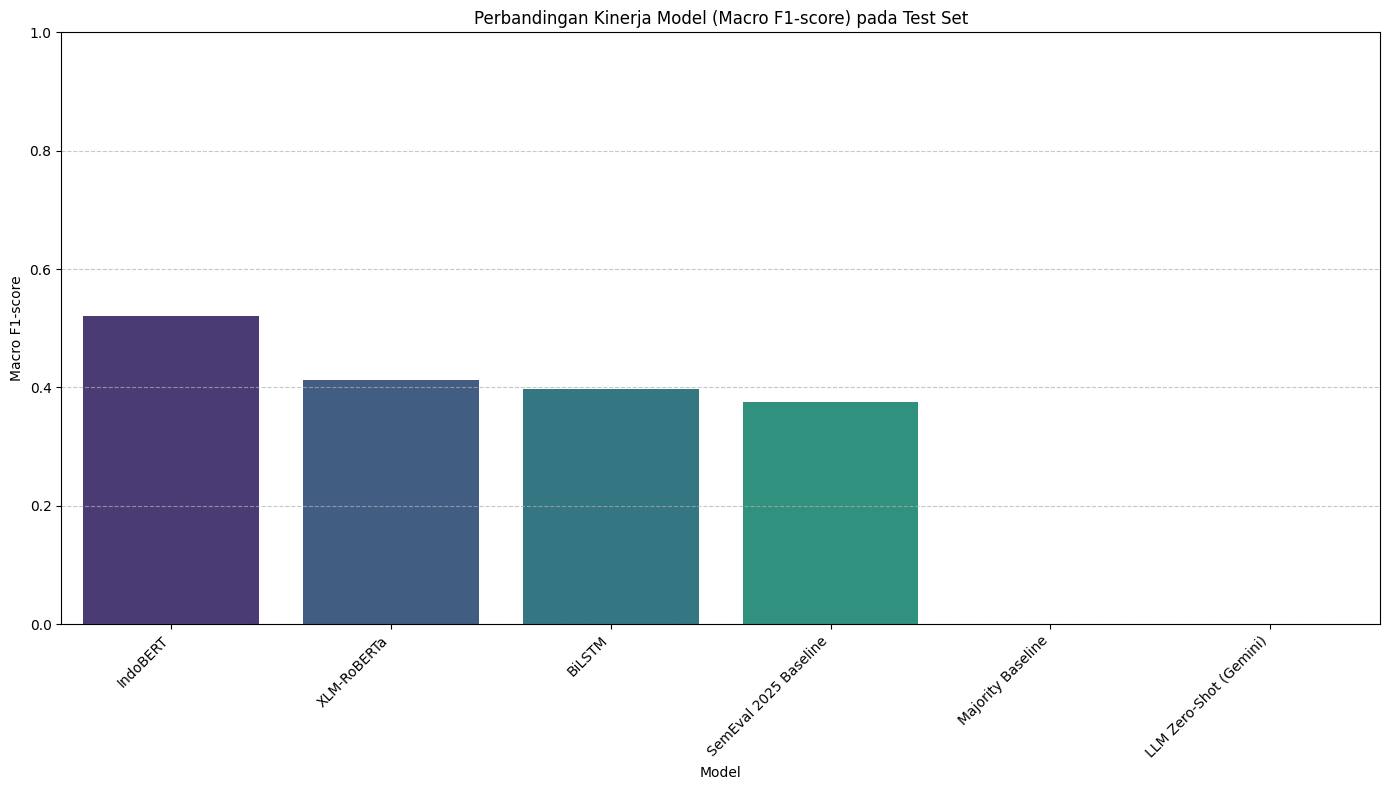

/tmp/ipython-input-1239006243.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Micro F1", data=results_summary_df, palette="plasma")


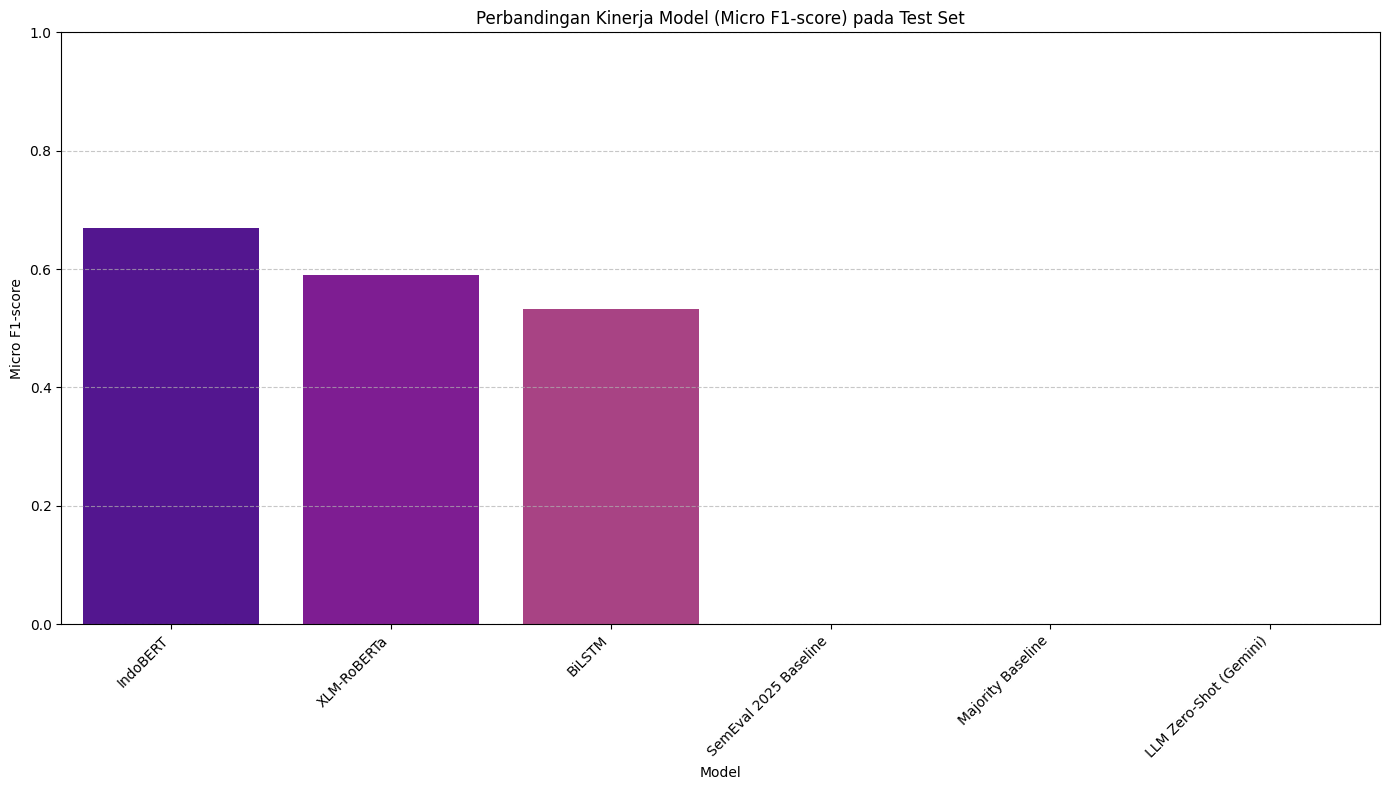

In [ ]:
# Visualisasi Hasil (Macro F1)
plt.figure(figsize=(14, 8))
sns.barplot(x="Model", y="Macro F1", data=results_summary_df, palette="viridis")
plt.title("Perbandingan Kinerja Model (Macro F1-score) pada Test Set")
plt.ylabel("Macro F1-score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("macro_f1_comparison.png") # Save the Macro F1 plot
plt.show()

# Visualisasi Hasil (Micro F1)
plt.figure(figsize=(14, 8))
sns.barplot(x="Model", y="Micro F1", data=results_summary_df, palette="plasma")
plt.title("Perbandingan Kinerja Model (Micro F1-score) pada Test Set")
plt.ylabel("Micro F1-score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("micro_f1_comparison.png") # Save the Micro F1 plot
plt.show()